In [108]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

df = pd.read_csv('./data-final.csv')

# remove header
df = df[2:]
head = df.head(0)

pd.set_option('future.no_silent_downcasting', True)

conditions = ['control', 'honest summary', 'honest chatbot', 'misleading summary', 'misleading chatbot']
sources = ['drug', 'pm', 'shoplift']

factor_cols = [
    "Q1",
    "Q2",
    "Q3_1", "Q3_2",
    "Q4_1", "Q4_2", "Q4_3", "Q4_4", "Q4_5", "Q4_6","Q4_7",
    "Q7",
    "Q8",
    "Q9"
]

for i in ["Q3_1", "Q3_2", "Q4_1", "Q4_2", "Q4_3", "Q4_4", "Q4_5", "Q4_6","Q4_7"]:
    df[i] = df[i].astype(float).apply(lambda x: 0 if math.isnan(x) else x - 12)
    
for i in factor_cols:
    df[i] = df[i].fillna(0).astype(int)

In [109]:
filtered = df[df['1_qs-drug-ans'].apply(lambda x: isinstance(x, str)) |
              df['1_qs-pm-ans'].apply(lambda x: isinstance(x, str)) |
              df['1_qs-shoplift-ans'].apply(lambda x: isinstance(x, str))].copy()

filtered['sum'] = filtered[
             [*[f"{i}_qs-drug-ans" for i in [*range(11,16)]],
              *[f"{i}_qs-pm-ans" for i in [*range(11,16)]],
              *[f"{i}_qs-shoplift-ans" for i in [*range(11,16)]]
             ]].replace({ "1": 1, "2": 0, "3": 0}).fillna(0).sum(axis=1).astype(int)

# filtered[["sum", *[f"{i}_qs-drug-ans" for i in [*range(11,16)]],
#               *[f"{i}_qs-pm-ans" for i in [*range(11,16)]],
#               *[f"{i}_qs-shoplift-ans" for i in [*range(11,16)]]]]

In [110]:
filtered['familiarity'] = filtered['Q1']
filtered['forgetting'] = filtered['Q2'].astype(int)
filtered['memory'] = filtered[['Q3_1', 'Q3_2']].sum(axis=1)
filtered['skepticism'] = filtered[[f"Q4_{i}" for i in [*range(1,8)]]].sum(axis=1)
filtered['age'] = filtered['Q7']
filtered['education'] = filtered['Q8'].astype(int)
filtered['gender'] = filtered['Q9'].replace({ 1: "M", 2: "F", 3: "N"})

result = filtered[['sum', 'condition', 'source', 'familiarity', 'forgetting', 'memory', 'skepticism', 'age', 'education', 'gender']]

In [111]:
age = filtered['age'].to_numpy().astype(int)
print(f"M={np.mean(age)}, s.d.={np.std(age)}")

M=35.33870967741935, s.d.=11.571577454551326


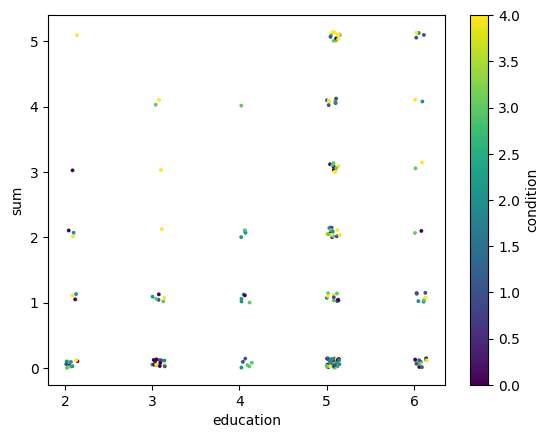

In [139]:
cc = 'education'

data = filtered[['sum', cc, 'condition']].to_numpy().tolist()
    # make each row into list of list -> [number, number][]
data_df = pd.DataFrame(data, columns = ['sum', cc, 'condition'])

data_df['sum'] = data_df['sum'] + 0.15 * np.random.rand(len(data_df))
data_df[cc] = data_df[cc] + 0.15 * np.random.rand(len(data_df))

# repalce condition with number
data_df = data_df.replace({'condition': {'control': 0, 'honest summary': 1, 'honest chatbot': 2, 'misleading summary': 3, 'misleading chatbot': 4}})

# make point smaller
ax1 = data_df.plot.scatter(x=cc, y='sum', c='condition', colormap='viridis', s=3)

In [115]:
result

,sum,condition,source,familiarity,forgetting,memory,skepticism,age,education,gender
3,1,misleading summary,pm,4,3,10,43,28,4,M
4,0,control,pm,3,4,14,35,35,6,F
5,0,control,drug,6,7,12,14,48,2,F
6,0,honest summary,shoplift,5,6,12,21,45,5,F
7,0,honest summary,pm,5,5,12,38,39,4,F
...,...,...,...,...,...,...,...,...,...,...
191,0,misleading chatbot,shoplift,7,6,12,26,24,5,M
192,0,honest summary,drug,6,5,7,48,44,6,F
193,4,honest chatbot,shoplift,7,5,12,26,24,5,F
194,2,misleading chatbot,pm,4,5,14,31,29,5,M


In [132]:
import statsmodels.formula.api as smf

#  + C(education, Treatment('High school diploma or GED'))
model = smf.mixedlm("sum ~ source + familiarity + forgetting + memory + education + age + skepticism + gender",
                    filtered,
                    groups= "condition").fit()

model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:              MixedLM   Dependent Variable:   sum      
No. Observations:   186       Method:               REML     
No. Groups:         5         Scale:                2.3572   
Min. group size:    35        Log-Likelihood:       -358.4927
Max. group size:    40        Converged:            Yes      
Mean group size:    37.2                                     
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           2.182    1.007  2.166 0.030  0.207  4.156
source[T.pm]        0.494    0.280  1.766 0.077 -0.054  1.042
source[T.shoplift]  0.008    0.279  0.030 0.976 -0.539  0.556
gender[T.M]         0.334    0.236  1.417 0.157 -0.128  0.797
familiarity        -0.004    0.088 -0.040 0.968 -0.176  0.169
forgetting         -0.020    0.095 -0.213 0.831 -0.207  0.166
memory             -0.138    0.050 -2.769 0.006 -0.235 -0.040
education           0.243    0.096  2.521 0.012  0.054  0.431
age                -0.010    0.010 -0.969 0.333 -0.030  0.010
skepticism         -0.007    0.012 -0.540 0.589 -0.031  0.017
condition Var       0.284    0.161                           
=============================================================

"""